In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities, asyn_lpa_communities, louvain_communities
%matplotlib inline

In [12]:
# Replace 'netflix_titles.csv' with the actual path of your dataset
df = pd.read_csv('netflix_titles.csv')

# Drop rows with missing values in 'cast' or 'country' columns
df = df.dropna(subset=['cast', 'country'])

# Function to extract the first country from a string of countries separated by commas
def extract_first_country(country_string):
    # Split the string by commas and return the first element
    countries = country_string.split(', ')
    return countries[0]

# Apply the extract_first_country function to the 'country' column
df['country'] = df['country'].apply(lambda x: extract_first_country(x) if pd.notnull(x) else x)

In [13]:
# Function to create pairs of actors from a list
def create_actor_pairs(actors_list):
    pairs = [(actor1, actor2) for i, actor1 in enumerate(actors_list) for j, actor2 in enumerate(actors_list) if i < j]
    return pairs

# Create a list of actor pairs for each movie
df['actor_pairs'] = df['cast'].apply(lambda x: create_actor_pairs(x.split(', ')))

# Flatten the list of actor pairs and count occurrences
all_actor_pairs = [pair for pairs_list in df['actor_pairs'] for pair in pairs_list]
pair_counts = pd.Series(all_actor_pairs).value_counts()

# Create a graph
G = nx.Graph()

# Add edges with actor pairs as nodes and pair counts as edge weights
for actor_pair, count in pair_counts.items():
    G.add_edge(actor_pair[0], actor_pair[1], weight=count)

In [14]:
def print_graph_info_ratios(graph):
    # Get the connected components
    connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)
    
    # Calculate the size of the whole network
    network_size = len(graph.nodes)
    
    num_components = len(connected_components)
    
    print("Number of Connected Components:", num_components)
    print("Ratios of Connected Component Sizes to Whole Network Size:")
    for idx, component in enumerate(connected_components, 1):
        component_size = len(component)
        ratio = component_size / network_size
        print("Component {}: Size {}, Ratio: {:.4f}".format(idx, component_size, ratio))
    
    print("\nSize of the Whole Network:", network_size)

print_graph_info_ratios(G)

Number of Connected Components: 453
Ratios of Connected Component Sizes to Whole Network Size:
Component 1: Size 30937, Ratio: 0.9111
Component 2: Size 37, Ratio: 0.0011
Component 3: Size 24, Ratio: 0.0007
Component 4: Size 23, Ratio: 0.0007
Component 5: Size 20, Ratio: 0.0006
Component 6: Size 20, Ratio: 0.0006
Component 7: Size 19, Ratio: 0.0006
Component 8: Size 18, Ratio: 0.0005
Component 9: Size 18, Ratio: 0.0005
Component 10: Size 17, Ratio: 0.0005
Component 11: Size 17, Ratio: 0.0005
Component 12: Size 16, Ratio: 0.0005
Component 13: Size 16, Ratio: 0.0005
Component 14: Size 16, Ratio: 0.0005
Component 15: Size 16, Ratio: 0.0005
Component 16: Size 16, Ratio: 0.0005
Component 17: Size 15, Ratio: 0.0004
Component 18: Size 15, Ratio: 0.0004
Component 19: Size 15, Ratio: 0.0004
Component 20: Size 15, Ratio: 0.0004
Component 21: Size 15, Ratio: 0.0004
Component 22: Size 14, Ratio: 0.0004
Component 23: Size 14, Ratio: 0.0004
Component 24: Size 14, Ratio: 0.0004
Component 25: Size 14, 

In [15]:
def get_largest_connected_component(graph):
    # Get the connected components
    connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)
    
    # Return the largest connected component
    if connected_components:
        largest_component_nodes = connected_components[0]
        largest_component = graph.subgraph(largest_component_nodes).copy()
        return largest_component
    else:
        return None
    
G = get_largest_connected_component(G)


# Add "country" as a property to each node
for actor in G.nodes():
    # Get the country for the actor from the DataFrame
    actor_country = df.loc[df['cast'].apply(lambda x: actor in x.split(', ')), 'country'].iloc[0]
    # Assign the 'country' as a property to the node
    G.nodes[actor]['country'] = actor_country

In [16]:
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  30937
Number of edges:  260645

Average degree:  16.85005010181983
Average degree (alternate calculation) 16.85005010181983

Minimum degree:  1
Maximum degree:  273


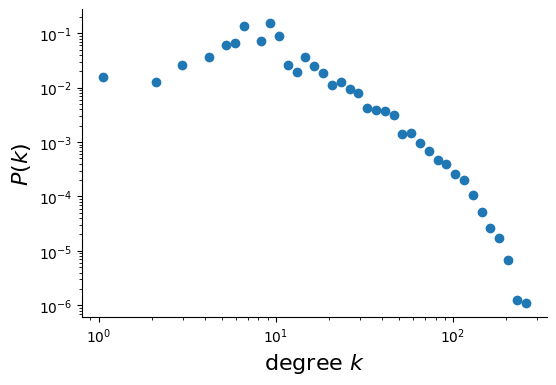

In [17]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=50)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

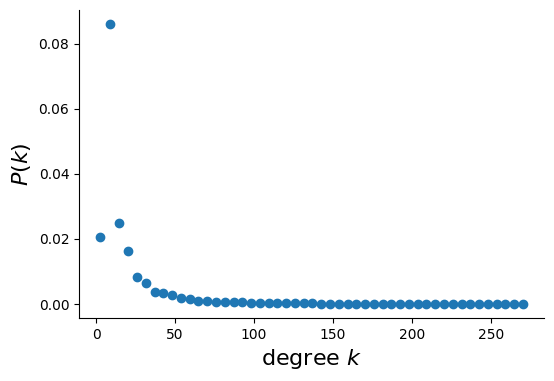

In [18]:
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, kmax, num=50)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [ ]:
# ...and calculate the clustering coefficient and average path length

C = np.mean(list(nx.clustering(G).values()))
d = nx.average_shortest_path_length(G,weight=None)

print("Average Clustering Coefficient: ", C)
print("Average Shortest Path: ", d)

In [21]:
# List of community detection algorithms
algorithms = {
    "greedy_modularity": greedy_modularity_communities,
    "asyn_lpa": asyn_lpa_communities,
    "louvain": louvain_communities
}

# Iterate over each algorithm
for algo_name, algo_func in algorithms.items():
    communities = list(algo_func(G))

    # Assign communities to nodes
    for idx, comm in enumerate(communities):
        for node in comm:
            if 'community_' + algo_name not in G.nodes[node]:
                G.nodes[node]['community_' + algo_name] = []
            G.nodes[node]['community_' + algo_name].append(idx)

In [22]:
# Convert lists to strings
for node in G.nodes():
    for key, value in G.nodes[node].items():
        if isinstance(value, list):
            G.nodes[node][key] = ','.join(map(str, value))


# Initialize lists to store results
results = []

# Define the list of community attributes
community_attributes = ['community_greedy_modularity', 'community_asyn_lpa', 'community_louvain']

# Iterate over each community attribute
for comm_attr in community_attributes:
    # Extract node attributes into a DataFrame
    node_data = [(node, data['country'], data[comm_attr]) for node, data in G.nodes(data=True)]
    df = pd.DataFrame(node_data, columns=['node', 'country', 'community'])

    # Find the most common country for each community
    most_common = df.groupby('community')['country'].agg(lambda x: x.value_counts().index[0]).reset_index()

    # Calculate the count of occurrences for the most common country
    most_common_count = df.groupby(['community', 'country']).size().reset_index(name='count')
    most_common_count = most_common_count.loc[most_common_count.groupby('community')['count'].idxmax()]

    # Merge the most common country and its count back to the main DataFrame
    most_common = pd.merge(most_common, most_common_count[['community', 'country', 'count']], on=['community', 'country'])

    # Calculate the total count for each community
    total_count = df.groupby('community')['country'].count().reset_index()
    total_count.columns = ['community', 'total_count']

    # Merge the total count back to the main DataFrame
    most_common = pd.merge(most_common, total_count, on='community')

    # Calculate the ratio
    most_common['ratio'] = most_common['count'] / most_common['total_count']

    # Calculate the weighted average
    weighted_avg = (most_common['ratio'] * most_common['total_count']).sum() / most_common['total_count'].sum()

    # Sort by count
    most_common = most_common.sort_values(by='count', ascending=False)

    # Append results for this community attribute
    results.append({
        'algorithm': comm_attr.replace('community_', ''),
        'most_common_country': most_common['country'].iloc[0],
        'weighted_avg': weighted_avg
    })

# Combine results into a single DataFrame
results_df = pd.DataFrame(results)

# Print the results
print("Results for each algorithm:")
print(results_df)

Results for each algorithm:
           algorithm most_common_country  weighted_avg
0  greedy_modularity       United States      0.623073
1           asyn_lpa       United States      0.903016
2            louvain       United States      0.748683


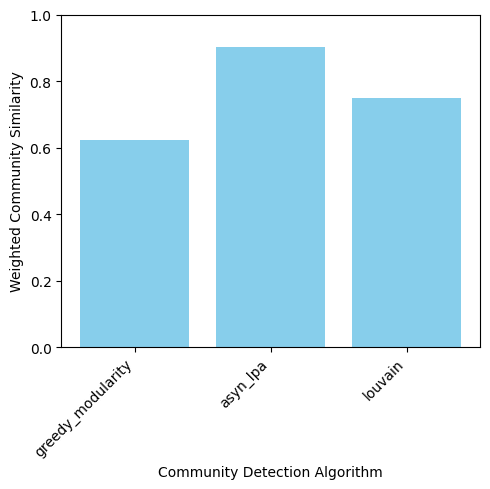

In [23]:
# Create a bar chart for weighted average ratio
plt.figure(figsize=(5, 5))
plt.bar(results_df['algorithm'], results_df['weighted_avg'], color='skyblue')
plt.xlabel('Community Detection Algorithm')
plt.ylabel('Weighted Community Similarity')
plt.yticks(np.arange(0, 1.1, step=0.2))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [24]:
# Get degrees of all nodes in the graph
node_degrees = dict(G.degree())

# Sort the nodes by their degree in descending order
sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)

# Print the 10 nodes with the highest degrees
print("Top 10 nodes with highest degree:")
for node, degree in sorted_nodes[:10]:
    print(f"Node {node}: Degree {degree}")

Top 10 nodes with highest degree:
Node Anupam Kher: Degree 273
Node Samuel L. Jackson: Degree 230
Node Yuichi Nakamura: Degree 216
Node Yuki Kaji: Degree 209
Node Shah Rukh Khan: Degree 209
Node Fred Tatasciore: Degree 207
Node Fred Armisen: Degree 199
Node Akshay Kumar: Degree 193
Node Takahiro Sakurai: Degree 192
Node Om Puri: Degree 187


In [ ]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G)

# Get the top 10 nodes with highest betweenness centrality
top_10_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

# Add 'bridge' attribute to the top 10 nodes
for node, centrality in top_10_nodes:
    G.nodes[node]['bridge'] = True
    print(f"Node {node}: Betweenness Centrality = {centrality}")


# For other nodes, set 'bridge' attribute to False
for node in G.nodes():
    if node not in dict(top_10_nodes).keys():
        G.nodes[node]['bridge'] = False

In [25]:
# Get the edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')

# Sort the edges by their weight in descending order
sorted_edges = sorted(edge_weights.items(), key=lambda x: x[1], reverse=True)

# Print the 10 edges with the highest weights
print("Top 10 edges with highest weight:")
for edge, weight in sorted_edges[:10]:
    nodes = edge
    print(f"{nodes[0]} -- {nodes[1]}: Weight {weight}")

Top 10 edges with highest weight:
John Paul Tremblay -- John Dunsworth: Weight 10
Robb Wells -- John Dunsworth: Weight 10
Junko Takeuchi -- Chie Nakamura: Weight 10
Ashleigh Ball -- Tabitha St. Germain: Weight 9
Junko Takeuchi -- Kazuhiko Inoue: Weight 8
Chie Nakamura -- Kazuhiko Inoue: Weight 8
Kappei Yamaguchi -- Kumiko Watanabe: Weight 8
Kappei Yamaguchi -- Satsuki Yukino: Weight 8
Kappei Yamaguchi -- Koji Tsujitani: Weight 8
Kappei Yamaguchi -- Houko Kuwashima: Weight 8
